# Práctica 1 - Red Neuronal

### Utilidades

#### Configuración del dispositivo de cómputo
Selecciona automáticamente GPU si está disponible, o CPU en caso contrario, e imprime el dispositivo usado para entrenar la red.

In [ ]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Usando dispositivo:", DEVICE)

#### Fijación de semilla para reproducibilidad
La siguiente función, `seed_everything`, asegura que los experimentos sean reproducibles fijando la semilla para PyTorch, CUDA, NumPy y el generador de números aleatorios de Python. También configura CUDA para un comportamiento determinista cuando se usa GPU.

In [ ]:
import random
import numpy as np

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#### Preparación de datasets y dataloaders

**`get_train_transforms()`**  
Define y construye el conjunto de **transformaciones aplicadas durante el entrenamiento**.  
Incluye:
- Conversión a escala de grises (1 o 3 canales según lo requerido por el modelo).
- Técnicas de *data augmentation* (recorte aleatorio, rotación, traslación, blur, etc.).
- Conversión a tensor y borrado aleatorio (*Random Erasing*).

Estas transformaciones aumentan la variabilidad de los datos, reducen el sobreajuste y mejoran la capacidad de generalización del modelo.

---

**`get_eval_transforms()`**  
Define las transformaciones aplicadas en **validación y test**.  
En este caso **no se utiliza data augmentation**, solo:
- Conversión a escala de grises.
- Redimensionamiento al tamaño objetivo.
- Conversión a tensor.

El objetivo es mantener las imágenes de evaluación consistentes y medir el rendimiento del modelo sin alteraciones aleatorias.

---

**`prepare_dataloaders()`**  
Función principal encargada de:
1. Aplicar las transformaciones correspondientes según el tipo de conjunto (entrenamiento o evaluación).  
2. Cargar las imágenes desde las carpetas `train/`, `val/` y `test`.  
3. Crear los **DataLoader** de PyTorch para cada conjunto:  
   - `train_loader` (con *shuffle*)  
   - `val_loader`  
   - `test_loader`  
4. Devolver también la lista de clases del dataset.

Esta función proporciona un pipeline modular y limpio para preparar los datos, compatible con cualquier modelo.


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# TRANSFORMACIONES DE ENTRENAMIENTO
def get_train_transforms(img_size=(48, 48), output_channels=1):
    
    transform_list = []

    # Convertir canales
    if output_channels == 1:
        transform_list.append(transforms.Grayscale(num_output_channels=1))
    elif output_channels == 3:
        # Si las imágenes son grises pero quieres 3 canales para ResNet
        transform_list.append(transforms.Grayscale(num_output_channels=3))
    else:
        raise ValueError("output_channels debe ser 1 o 3.")

    # Data augmentation
    transform_list += [
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1)
        ),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.25)
    ]

    return transforms.Compose(transform_list)


# TRANSFORMACIONES DE VALIDACIÓN/TEST
def get_eval_transforms(img_size=(48, 48), output_channels=1):

    transform_list = []

    if output_channels == 1:
        transform_list.append(transforms.Grayscale(num_output_channels=1))
    elif output_channels == 3:
        transform_list.append(transforms.Grayscale(num_output_channels=3))

    transform_list += [
        transforms.Resize(img_size),
        transforms.ToTensor()
    ]

    return transforms.Compose(transform_list)


# FUNCIÓN PRINCIPAL: DATALOADERS
def prepare_dataloaders(
        dataset_path: str,
        batch_size=64,
        img_size=(48, 48),
        output_channels=1,
        num_workers=2):

    train_transform = get_train_transforms(img_size, output_channels)
    eval_transform  = get_eval_transforms(img_size, output_channels)

    train_dir = os.path.join(dataset_path, 'train')
    val_dir   = os.path.join(dataset_path, 'val')
    test_dir  = os.path.join(dataset_path, 'test')

    train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
    val_dataset   = datasets.ImageFolder(root=val_dir, transform=eval_transform)
    test_dataset  = datasets.ImageFolder(root=test_dir, transform=eval_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader, train_dataset.classes

#### Gráfico de las curvas de accuracy durante el entrenamiento y la validación de la red neuronal.
A continuación, se definirá una función que muestre cómo cambian la pérdida (loss) y la precisión (accuracy) del modelo en entrenamiento y validación a lo largo de las épocas. Esto permite evaluar el aprendizaje de la red, detectar overfitting o underfitting, y comparar el desempeño entre diferentes configuraciones del modelo.

La precisión se calcula como:
$$
\text{Accuracy} = \frac{\text{Número de predicciones correctas}}{\text{Número total de predicciones}} \times 100\%
$$

In [36]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Dibuja las curvas de loss y accuracy (train y dev) guardadas en el diccionario 'history'.
    Espera claves: 'train_loss', 'train_acc', 'val_loss', 'val_acc'.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # --- Loss ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # --- Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#### Matriz de confusión
Asimismo, la siguiente función muestra la comparación entre las etiquetas reales (`y_true`) y las predicciones del modelo (`y_pred`) para cada clase. Permite identificar qué clases se confunden entre sí y evaluar detalladamente el desempeño del modelo en clasificación.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    if y_true is None or y_pred is None: return
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title); plt.ylabel('Etiqueta Real'); plt.xlabel('Etiqueta Predicha')
    plt.tight_layout(); plt.show()

#### Guardar campos en el CSV

In [ ]:
import json
import pandas as pd
import os

def save_results(all_results):
    if not all_results: 
        return
    
    df_results = pd.DataFrame(all_results)
    df_results["history_dict"] = df_results["history_dict"].apply(json.dumps)
    df_results["y_true"] = df_results["y_true"].apply(lambda x: json.dumps(x.tolist()))
    df_results["y_pred"] = df_results["y_pred"].apply(lambda x: json.dumps(x.tolist()))

    # Cada experimento como columna
    df_csv = df_results.T
    csv_filename = "resultados_cnn_fer_ds_modificado.csv"

    def decimal_to_comma(df):
        return df.applymap(lambda x: str(x).replace('.', ',') if isinstance(x, (float, int)) else x)

    if not os.path.exists(csv_filename):
        df_to_save = decimal_to_comma(df_csv)
        df_to_save.to_csv(csv_filename, sep=';', index=True)

    else:
        # Cargar CSV anterior
        df_prev = pd.read_csv(csv_filename, sep=';', index_col=0)

        # Preparar nuevo bloque
        df_new = decimal_to_comma(df_csv)

        # Asegurar que los índices coincidan
        df_prev, df_new = df_prev.align(df_new, join='outer')

        # Concatenar como columnas
        df_combined = pd.concat([df_prev, df_new], axis=1)

        df_combined.to_csv(csv_filename, sep=';', index=True)

    print(f"Resultados guardados en: {csv_filename}\n")

#### Leer desde el CSV

In [33]:
import ast

def robust_json_load(x):
    """
    Intenta cargar JSON de forma estricta. Si falla, intenta corregir
    formatos comunes (comillas simples, booleanos de Python, etc.)
    usando ast.literal_eval.
    """
    if not isinstance(x, str):
        return x
    try:
        return json.loads(x)
    except (json.JSONDecodeError, TypeError):
        try:
            return ast.literal_eval(x.replace("null", "None").replace("true", "True").replace("false", "False"))
        except Exception as e:
            print(f"Error decodificando: {e}")
            return None

def load_all_experiments_from_csv(csv_filename):
    # 1. Leer con el separador correcto (punto y coma según tu archivo)
    df = pd.read_csv(csv_filename, sep=';', index_col=0)
    
    # 2. Transponer (Filas = Experimentos)
    df = df.T
    
    # 3. Convertir columnas JSON de forma robusta
    json_cols = ["history_dict", "y_true", "y_pred"]
    for col in json_cols:
        if col in df.columns:
            df[col] = df[col].apply(robust_json_load)
            
    # 4. Convertir test_acc a float manejando la coma decimal
    if "test_acc" in df.columns:
        # Reemplaza ',' por '.' y convierte a float
        df["test_acc"] = df["test_acc"].astype(str).str.replace(',', '.').astype(float)
        
    return df

#### Analizar mejor y peor experimento

In [32]:
def analyze_from_csv(csv_filename, classes):
    df = pd.read_csv(csv_filename, sep=';', index_col=0).T
    json_cols = ["history_dict", "y_true", "y_pred"]
    for col in json_cols:
        if col in df.columns: df[col] = df[col].apply(robust_json_load)
    if "test_acc" in df.columns:
        df["test_acc"] = df["test_acc"].astype(str).str.replace(',', '.').astype(float)

    best = df.loc[df["test_acc"].idxmax()]
    worst = df.loc[df["test_acc"].idxmin()]

    print(f"🏆 Mejor: {best['name']} - {best['test_acc']}%")
    print(f"📉 Peor: {worst['name']} - {worst['test_acc']}%")

    plot_training_history(best["history_dict"])
    plot_confusion_matrix(best["y_true"], best["y_pred"], classes, f"Confusion ({best['name']})")

    plot_training_history(worst["history_dict"])
    plot_confusion_matrix(worst["y_true"], worst["y_pred"], classes, f"Confusion ({worst['name']})")

### Entrenamiento CNN desde cero

#### Modelo

Este bloque define un **modelo CNN completamente modular y configurable**. Permite ajustar el número de capas convolucionales, filtros, kernel sizes, repeticiones, y también la estructura de las capas densas.

- **Bloques convolucionales**: cada bloque aplica varias Conv2D + LeakyReLU para extraer características, seguido de MaxPool para reducir la resolución espacial y Dropout para evitar sobreajuste.

- **Cálculo automático del tamaño plano**: se usa un `dummy_input` para pasar por la parte convolucional y obtener automáticamente el tamaño exacto que debe recibir la primera capa densa.

- **Capas densas (FC)**: construyen un clasificador configurable, con activaciones LeakyReLU y Dropout para regularización.

- **Capa final**: genera la salida final del modelo, lista para usar con `CrossEntropyLoss` (por eso no contiene Softmax).

In [ ]:
import torch.nn as nn

class ModularCNN(nn.Module):
    def __init__(self, input_shape, conv_layers, fc_layers, num_classes, dropout_conv=0.3, dropout_fc=0.4):
        super(ModularCNN, self).__init__()
        
        self.features = nn.Sequential()
        in_channels = input_shape[2]
        
        # --- BLOQUES CONVOLUCIONALES ---
        for i, (out_channels, k, reps) in enumerate(conv_layers):
            for _ in range(reps):
                self.features.add_module(f"conv_{i}_{_}", nn.Conv2d(in_channels, out_channels, kernel_size=k, padding=k//2))
                self.features.add_module(f"relu_{i}_{_}", nn.LeakyReLU(0.1))
                in_channels = out_channels
            
            self.features.add_module(f"pool_{i}", nn.MaxPool2d(2, 2))
            self.features.add_module(f"drop_{i}", nn.Dropout(dropout_conv))

        # --- CAPAS DENSAS ---
        self._to_linear = None
        dummy_input = torch.zeros(1, input_shape[2], input_shape[0], input_shape[1])
        dummy_out = self.features(dummy_input)
        self.flat_dim = int(np.prod(dummy_out.size()))
        
        self.classifier = nn.Sequential()
        in_features = self.flat_dim
        
        for i, units in enumerate(fc_layers):
            self.classifier.add_module(f"fc_{i}", nn.Linear(in_features, units))
            self.classifier.add_module(f"relu_fc_{i}", nn.LeakyReLU(0.1))
            self.classifier.add_module(f"drop_fc_{i}", nn.Dropout(dropout_fc))
            in_features = units
            
        # Capa final (Sin Softmax, CrossEntropyLoss lo aplica internamente)
        self.classifier.add_module("fc_out", nn.Linear(in_features, num_classes))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x

#### Entrenar modelo

##### Entreno de una época

`train_one_epoch`: Entrena el modelo durante una época completa.

**Pasos principales:**
- `model.train()`: activa el modo entrenamiento (Dropout, BatchNorm).
- Itera sobre el `DataLoader` para obtener lotes de imágenes y etiquetas.
- Mueve los datos al dispositivo (`CPU/GPU`).
- Realiza el **forward** (`outputs = model(images)`).
- Calcula la **pérdida** con la función `criterion`.
- Hace **backpropagation** (`loss.backward()`).
- Actualiza los pesos con `optimizer.step()`.
- Acumula pérdida y aciertos para calcular:
  - **epoch_loss**: pérdida media de la época.
  - **epoch_acc**: accuracy de la época.

**Salida**:  `(epoch_loss, epoch_acc)`

`validate`: Evalúa el modelo en el conjunto de validación sin actualizar pesos. 

**Pasos principales:**
- `model.eval()`: modo evaluación (Dropout desactivado).
- `with torch.no_grad()`: no calcula gradientes para ahorrar memoria/tiempo.
- Itera sobre el `DataLoader`.
- Calcula:
  - **Loss total** del conjunto.
  - **Accuracy** basado en predicciones correctas.

**Salida**:  `(val_loss, val_acc)`  

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss / total, correct / total

##### EarlyStopping

La clase `EarlyStopping` sirve para **detener el entrenamiento de un modelo automáticamente** si la métrica de interés (por ejemplo, accuracy de validación) deja de mejorar durante varias épocas consecutivas.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=8, mode='max', verbose=False):
        self.patience = patience
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, current_score, model):
        score = current_score if self.mode == 'max' else -current_score

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_weights(self, model):
        if self.best_model_state:
            model.load_state_dict(self.best_model_state)

##### Entrenamiento completo

Esta función realiza un **entrenamiento completo del modelo** con validación y early stopping.

**Pasos principales:**

1. **Definir criterio y optimizador**  
   - `criterion = CrossEntropyLoss()` → calcula la pérdida de clasificación.  
   - `optimizer = Adam` → actualiza los pesos del modelo.

2. **EarlyStopping**  
   - Monitorea la métrica de validación (`val_acc`).  
   - Detiene el entrenamiento si no mejora durante `patience` épocas.  
   - Guarda los mejores pesos automáticamente.

3. **Entrenamiento por épocas**  
   Para cada época:
   - `train_one_epoch`: realiza entrenamiento completo de la época.
   - `validate`: evalúa el modelo en el conjunto de validación.
   - Se registran las métricas (`loss` y `accuracy`) en el historial.
   - Se imprime el progreso de la época.

4. **Chequeo de EarlyStopping**  
   - Si la métrica de validación no mejora, se detiene el entrenamiento antes de llegar al número máximo de épocas.

5. **Cargar los mejores pesos**  
   - Después de terminar, `es.load_best_weights(model)` restaura los pesos del modelo con mejor rendimiento en validación.

**Salida:**  
- `history`: diccionario con listas de pérdidas y accuracies para entrenamiento y validación.

In [ ]:
import torch.optim as optim

def train_experiment(model, train_loader, val_loader, epochs, lr, patience):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    es = EarlyStopping(patience=patience, mode='max', verbose=True)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        v_loss, v_acc = validate(model, val_loader, criterion)
        
        history['train_loss'].append(t_loss)
        history['train_acc'].append(t_acc)
        history['val_loss'].append(v_loss)
        history['val_acc'].append(v_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {t_loss:.4f} - Acc: {t_acc:.4f} - Val Loss: {v_loss:.4f} - Val Acc: {v_acc:.4f}")
        
        es(v_acc, model)
        if es.early_stop:
            print("Early stopping triggered")
            break
            
    es.load_best_weights(model)
    return history

#### Evaluar modelo

Esta función **evalúa el rendimiento del modelo** en un conjunto de datos (por ejemplo, test o validación) y devuelve métricas detalladas.

**Pasos principales:**
- `model.eval()`: modo evaluación (Dropout desactivado).
- `with torch.no_grad()`: no calcula gradientes para ahorrar memoria/tiempo.
- Función de pérdida: `CrossEntropyLoss()
- Itera sobre el `DataLoader`.
    Para cada lote:
    - Mueve imágenes y etiquetas al dispositivo (CPU/GPU)
    - Calcula las predicciones (outputs = model(images)).
    - Calcula la pérdida (loss = criterion(outputs, labels)).
    - Guarda predicciones y etiquetas reales.
- Calcula métricas finales:
  - **Loss total**, pérdida promedio del conjunto.
  - **Accuracy** basado en predicciones correctas

**Salida**: 
- **acc**: accuracy total en porcentaje.
- **avg_loss**: pérdida promedio.
- **all_labels**: array con todas las etiquetas verdaderas.
- **all_preds**: array con todas las predicciones del modelo.

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    total = len(all_labels)
    acc = np.sum(np.array(all_preds) == np.array(all_labels)) / total * 100
    avg_loss = running_loss / total
    
    return acc, avg_loss, np.array(all_labels), np.array(all_preds)

#### Entrenamientos 

In [ ]:
import kagglehub

def main():
    """Función principal optimizada para maximizar Accuracy en FER-2013,
    con guardado completo en CSV y análisis desde histórico."""
    
    # --- Configuración global ---
    BATCH_SIZE = 64
    INPUT_CHANNELS = 1
    EPOCHS = 100

    # DEFINICIÓN DE EXPERIMENTOS
    EXPERIMENTS = [
        {
            "name": "Experimento 1",
            "conv_layers": [
                (64, 3, 2),   
                (128, 3, 2), 
                (256, 3, 2),  
                (512, 3, 2)   
            ],
            "fc_layers": [512, 256], 
            "lr": 1e-4,      
            "dropout_conv": 0.3,
            "dropout_fc": 0.5, 
            "epochs": EPOCHS      
        },
        {
            "name": "Experimento 2",
            "conv_layers": [
                (32, 3, 1), 
                (64, 3, 1), 
                (128, 3, 1), 
                (256, 3, 1),
                (512, 3, 1)
            ],
            "fc_layers": [1024, 256], 
            "lr": 2e-4,
            "dropout_conv": 0.25,
            "dropout_fc": 0.5,
            "epochs": EPOCHS
        },
        {
            "name": "Experimento 3",
            "conv_layers": [
                (64, 3, 1),
                (128, 3, 2),
                (256, 3, 2),
                (512, 3, 2)
            ],
            "fc_layers": [512, 256],
            "lr": 1e-4,
            "dropout_conv": 0.25,
            "dropout_fc": 0.5,
            "epochs": EPOCHS
        },
        {
            "name": "Experimento 4",
            "conv_layers": [
                (32, 3, 1),
                (64, 3, 1),
                (128, 3, 1),
                (256, 3, 1)
            ],
            "fc_layers": [256],
            "lr": 1e-3,
            "dropout_conv": 0.25,
            "dropout_fc": 0.4,
            "epochs": EPOCHS
        },
        {
            "name": "Experimento 5",
            "conv_layers": [
                (64, 3, 1),
                (128, 3, 2),
                (256, 3, 2),
                (512, 3, 2)
            ],
            "fc_layers": [512, 256],
            "lr": 1e-4,
            "dropout_conv": 0.2,
            "dropout_fc": 0.45,
            "epochs": EPOCHS
        },
        {
            "name": "Experimento 6",
            "conv_layers": [
                (64, 3, 2),
                (128, 3, 2),
                (256, 3, 4), 
                (512, 3, 4),  
            ],
            "fc_layers": [1024, 512],
            "lr": 5e-5,
            "dropout_conv": 0.25,
            "dropout_fc": 0.5,
            "epochs": EPOCHS
        }

    ]

    # 1. SETUP & DATOS
    seed_everything(42)
    print("Obteniendo dataset (FER-2013)...")
    dataset_path = "C:\\Users\\laura\\Downloads\\datos"

    # Preparar datos
    train_loader, val_loader, test_loader, classes = prepare_dataloaders(
        dataset_path=dataset_path,
        output_channels=INPUT_CHANNELS,
        batch_size=BATCH_SIZE,
        img_size=(48, 48)
    )

    print(f"Número de imágenes de entrenamiento: {len(train_loader.dataset)}")
    print(f"Número de imágenes de validación: {len(val_loader.dataset)}")
    print(f"Número de imágenes de test: {len(test_loader.dataset)}")


    all_results = []
    input_shape = (48, 48, INPUT_CHANNELS)
    
    # 2. EJECUCIÓN DE EXPERIMENTOS
    for exp in EXPERIMENTS:
        print("\n====================================")
        print(f"Entrenando experimento: {exp['name']}")
        print("====================================\n")

        # A. CONSTRUIR
        model = ModularCNN(
            input_shape=input_shape,
            conv_layers=exp["conv_layers"],
            fc_layers=exp["fc_layers"],
            dropout_conv=exp.get("dropout_conv", 0.3),
            dropout_fc=exp.get("dropout_fc", 0.4),
            num_classes=len(classes)
        ).to(DEVICE)

        # B. ENTRENAR
        history = train_experiment(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=exp["epochs"],
            lr=exp["lr"],
            patience=10 
        )

        # D. EVALUAR
        test_acc, test_loss, y_true, y_pred = evaluate_model(model, test_loader)
        print(f"[{exp['name']}] Test Accuracy = {test_acc:.4f}%")

        # E. ALMACENAR RESULTADOS
        result_entry = {
            "name": exp['name'],
            "conv_layers_config": str(exp["conv_layers"]),
            "fc_layers_config": str(exp["fc_layers"]),
            "learning_rate": exp["lr"],
            "dropout_conv": exp.get("dropout_conv", 0.3),
            "dropout_fc": exp.get("dropout_fc", 0.4),
            "epochs_run": len(history["train_loss"]),
            "test_loss": test_loss,
            "test_acc": test_acc,
            "history_dict": history,
            "y_true": y_true,
            "y_pred": y_pred
        }
        all_results.append(result_entry)

    # 3. GUARDAR EN CSV
    save_results(all_results)

    # 4. ANALIZAR HISTÓRICO COMPLETO DESDE EL CSV
    print("Analizando histórico completo desde CSV...")

    analyze_from_csv("resultados_cnn_fer_ds_modificado.csv", classes)


if __name__ == "__main__":
    main()


Iniciando análisis...
🏆 Mejor: Experimento 3 - 67.42273887156223%
📉 Peor: Experimento 4 - 60.10774028919762%


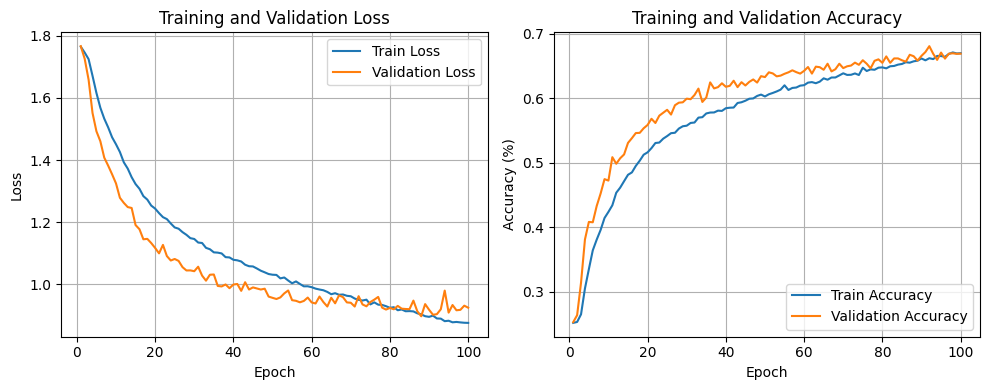

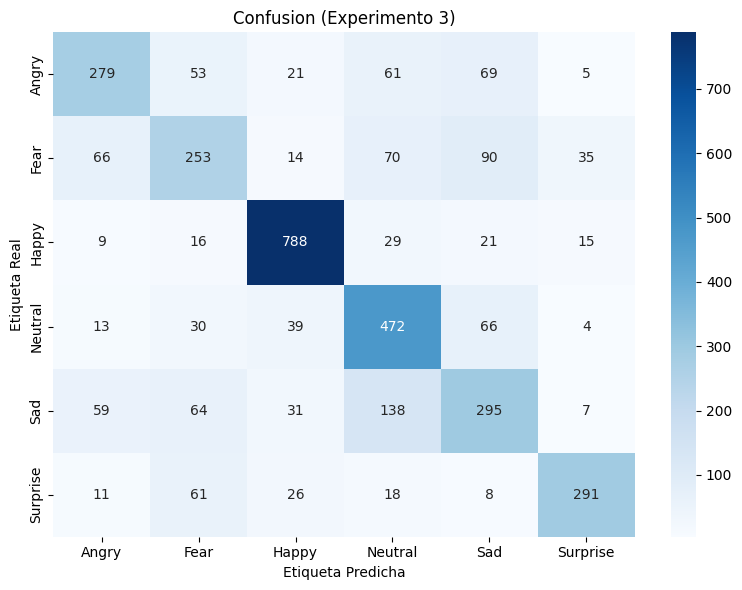

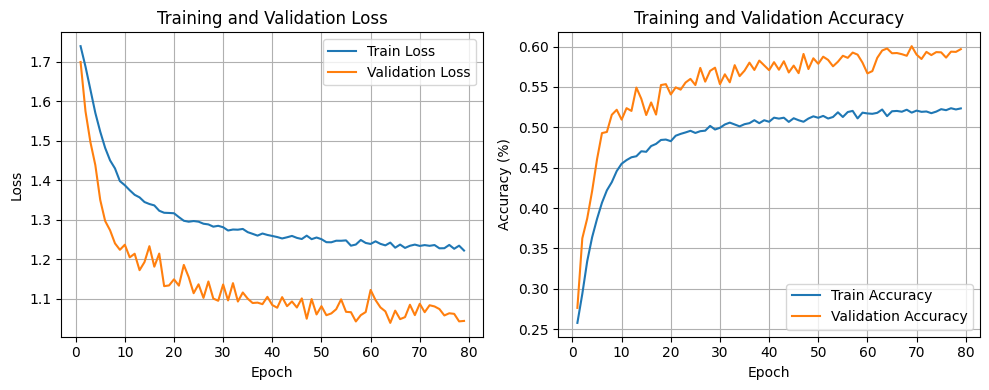

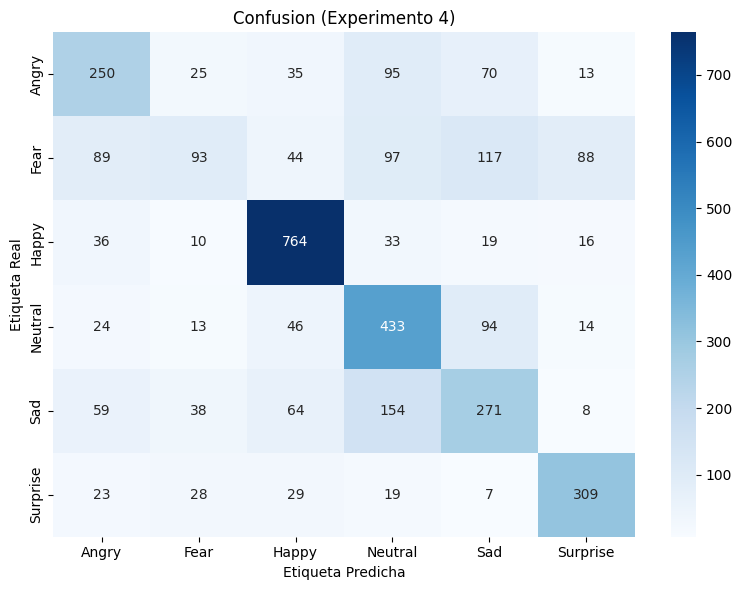

✅ Análisis completado.


In [37]:
dataset_path = "C:\\Users\\laura\\Downloads\\datos"
BATCH_SIZE = 64
INPUT_CHANNELS = 1

train_loader, val_loader, test_loader, classes = prepare_dataloaders(
        dataset_path=dataset_path,
        output_channels=INPUT_CHANNELS,
        batch_size=BATCH_SIZE,
        img_size=(48, 48)
    )    

try:
    print("Iniciando análisis...")
    analyze_from_csv("resultados_cnn_fer_ds_modificado.csv", classes)
    print("✅ Análisis completado.")
except Exception as e:
    print(f"❌ Error durante el análisis: {e}")